In [412]:
# import packages
import numpy as np
import math as math
import pandas as pd
from astropy import units as u
import astropy.constants as const
import random
import matplotlib.pyplot as plt
import os
from pylaplace import LaplaceCoefficient
from astropy.io import fits
from astropy.table import Table, hstack, vstack, Column
import itertools
#import seaborn as sns; sns.set_theme()

# Exploring relationships between planet rotation, obliquity, orbital eccentricity, inclination

$|g|$ is the observable nodal precession

When $g \sim \alpha$, they are _commensurate_ and can excite non-zero obliquity, $\epsilon$. 

$g$ is non-zero when there is >1 planets.


### $\alpha(\omega)$, precession of planet spin axis for a given spin freqency

$ \alpha $ - spin-axis precession constant

$ \epsilon $ - obliquity (of planet!)

Period of planet spin precession
$$ T_{\alpha} = \frac{2\pi}{\alpha ~ cos \epsilon} $$ 

Caused by torque from host star on rotationally-flattened planet 

$$ \alpha = \frac{1}{2}\frac{M_{*}}{m_p}\left(\frac{R_p}{a}\right)^3\frac{k_2}{C}\omega $$




In [2]:
def get_C(k2):
    """Calculate C, the moment of inertia, from k2, the Love number"""
    
    C = (2/3)*(1 - (2/5)*((5/(k2+1)) - 1)**0.5)
    return C

In [3]:
def get_alpha(omega, mstar, mp, rp, a, k2, C):
    """
    Calculate alpha, spin-axis precession constant for frequency of planet 
    rotational spin axis precessing around orbit normal
    
    Input:
        omega: spin frequency
        
    Returns:
        alpha: frequency constant in 1/yr
    """
    alpha = 0.5 * (mstar/mp) * (rp/a)**3 * (k2/C) * omega
    
    return alpha

In [4]:
# planet-star parameters for Earth
mstar = 1. * u.M_sun
mp = 1. * u.M_earth   # 17 Me Neptune
rp = 1. * u.R_earth   # 4 Re Neptune
a = 1. * u.astronomical_unit  # 30 AU Neptune
k2 = 0.31 # 0.2 * random.random() + 0.2  # Love number, 0.2-0.6 in Solar system
C = get_C(k2) # 0.2 * random.random() + 0.2 # moment of inertia normalized to planet
Prot = 365 * u.day #24. * u.h  # Jupiter spins once every 10 hours, which should be illegal

obl = 23.*np.pi/180. # planet obliquity 

print("Precession of Earth planet spin axis for a given spin freqency:")

# Calculate spin frequency 
w = (2*np.pi)/(Prot)
print(f"w = {w.to(1/u.s):.3}")

# Calculate precession constant
alpha = get_alpha(w, mstar, mp, rp, a, k2, C)
print(f"alpha(w) = {alpha:.4}")

# Calculate planet spin axis precession periodt
Ta = (2*np.pi)/(alpha) #* np.cos(obl))
print(f"T_a = {Ta.to(u.yr):.4} ")  

Precession of Earth planet spin axis for a given spin freqency:
w = 1.99e-07 1 / s
alpha(w) = 0.01218 earthRad3 solMass / (AU3 d earthMass)
T_a = 5.475e+07 yr 


In [5]:
# Assumming Prot = Porb (tidal locking)
# earth
earth_alpha = get_alpha((2*np.pi)/(365*u.day), 1*u.M_sun, 1*u.M_earth, 1*u.R_earth, 1*u.astronomical_unit, 0.33, get_C(0.33))
# neputne
neptune_alpha = get_alpha((2*np.pi)/(165*u.year), 1*u.M_sun, 17*u.M_earth, 4*u.R_earth, 30*u.astronomical_unit, 1, 1)

print(f"Earth: alpha = {earth_alpha}")
print(f"Neptune: alpha = {neptune_alpha}")

Earth: alpha = 0.01269739591792899 earthRad3 solMass / (AU3 d earthMass)
Neptune: alpha = 2.654808606717459e-06 earthRad3 solMass / (AU3 earthMass yr)


The values I get for precession period are about 10x larger than the ones in the paper. 
Unsure why...I suspect units.

### Calculating $g_{LL}$, orbit nodal regression (orbit precession) and $\alpha$, planet spin axis precession for a given system

If $g_{LL} \sim \alpha$, there is spin-orbit resonance, and that can mean high obliquity :3

$$ g_{LL} = -\frac{1}{4}b_{3/2}^{(1)}(\alpha_{12})\alpha_{12}\left(n_1 \frac{m_2}{M_{*} + m_1}\alpha_{12} + n_2\frac{m_1}{M_* + m_2} \right)  $$

where $\alpha_{12} = a_1/a_2 $ and $n_i$ is the mean motion of each planet and $b_{3/2}^{(1)}$ is a Laplace coefficient we solve for using `pylaplace`

In [6]:
##############################################
##  system information for Saturn-Neptune   ##
##############################################
print("Saturn-Neptune spin-orbit precession frequency")
mstar = 1. * u.M_sun   # Sun
m1 = 95.16 * u.M_earth     # Saturn
m2 = 17.15 * u.M_earth     # Neptune 
a1 = 9.573*u.AU    # Saturn
a2 = 30.178*u.AU   # Neptune
a12 = a1/a2
print(f"a12 = {a12}")

# planet mean-motion
n1 = np.sqrt((const.G * mstar)/a1**3)   # Periodt
n2 = np.sqrt((const.G * mstar)/a2**3) 
print(f"n1 = {n1.decompose():.5}; n2 = {n2.decompose():.5}")
# Laplace coefficient
laplace = LaplaceCoefficient()
# result = laplace(a, s, m, p, q)
# laplace coefficient, dependent on semi-major axis ratio
b = laplace(a12.value, 1.5, 1, 1, 1)  
print(f"b = {b}")

# calculate spin-axis precession
gll = -0.25*b*a12*( n1*(m2/(mstar+m1))*a12 + n2*(m1/(mstar+m2)) )
print(f"g_LL = {gll.to(1/u.yr):.5}")
print(f"T = 2pi/g = {((2*np.pi)/gll).to(u.Myr):.4}")

Saturn-Neptune spin-orbit precession frequency
a12 = 0.317217840811187
n1 = 6.722e-09 1 / s; n2 = 1.201e-09 1 / s
b = -1.1615290163287626
g_LL = 1.3169e-06 1 / yr
T = 2pi/g = 4.771 Myr


In [471]:
##############################################
## system information for Kepler-80/KOI-500 ##
##############################################
print("Kepler-80/KOI-500 d(1), e(2)")
mstar = 0.58 * u.M_sun     # Kepler-80
m1 = 2.0375316 * u.M_earth     # Kepler-80 d
m2 = 2.1171352 * u.M_earth     # Kepler-80 e 
a1 = 0.0346 * u.astronomical_unit         # Kepler-80 d
a2 = 0.0456 * u.astronomical_unit         # Kepler-80 e
a12 = a1/a2
print(f"a12 = {a12}")
P1 = 3.0721466 * u.day
P2 = 4.6453821 * u.day
w1 = (2*np.pi)/ P1 # Kepler-80 d
w2 = (2*np.pi)/ P2 # Kepler-80 e
print(f"w1 = {w1:.5} \nw2 = {w2:.5}")
r1 = 1.3 * u.R_earth
r2 = 1.33 * u.R_earth

# planet mean-motion
n1 = np.sqrt((const.G * mstar)/a1**3)
n2 = np.sqrt((const.G * mstar)/a2**3)
print(f"n1 = {n1.to(u.d**-1):.5}; n2 = {n2.to(u.d**-1):.5}")
# Laplace coefficient
laplace = LaplaceCoefficient()
# result = laplace(a, s, m, p, q)
b = laplace(a12.value, 1.5, 1, 1, 1)
print(f"b = {b}")

# calculate spin-axis precession
gll = -0.25*b*a12*( n1*(m2/(mstar+m1))*a12 + n2*(m1/(mstar+m2)) )
#alpha1 = get_alpha(w1,mstar,m1,r1,a1,1,1).to(u.Myr**-1)
#alpha2 = get_alpha(w2,mstar,m2,r2,a2,1,1).to(u.Myr**-1)
alpha1 = (0.5 * (mstar/m1) * (r1/a1)**3 * (1/1) * w1).to(u.Myr**-1)
alpha2 = (0.5 * (mstar/m2) * (r2/a2)**3 * (1/1) * w2).to(u.Myr**-1)
print(f"g_LL = {gll.to(1/u.Myr):.5}")
print(f"alpha_d = {alpha1:.5}")
print(f"alpha_e = {alpha2:.5}")

Kepler-80/KOI-500 d(1), e(2)
a12 = 0.7587719298245613
w1 = 2.0452 1 / d 
w2 = 1.3526 1 / d
n1 = 2.0355 1 / d; n2 = 1.3454 1 / d
b = -11.6543935473343
g_LL = 2.5136e+04 1 / Myr
alpha_d = 1.4551e+05 1 / Myr
alpha_e = 4.3324e+04 1 / Myr


In [472]:
# check of w1, w2
print(f"w1 = 2pi/P1 = {w1}, n1 = GMstar/a1^3: {n1.to(u.d**-1)}")
print(f"w2 = 2pi/P2 = {w2}, n2 = GMstar/a2^3: {n2.to(u.d**-1)}")

w1 = 2pi/P1 = 2.045210116984517 1 / d, n1 = GMstar/a1^3: 2.0355477287735853 1 / d
w2 = 2pi/P2 = 1.3525658755131438 1 / d, n2 = GMstar/a2^3: 1.3453899345260363 1 / d


### Find $g, \alpha, \epsilon$ for a large set of planets

Do this analysis for a large number of M dwarf systems

In [9]:
def get_alpha(omega, mstar, mp, rp, a, k2, C):
    """
    Calculate alpha, spin-axis precession constant for frequency of planet 
    rotational spin axis precessing around orbit normal
    
    Input:
        omega: spin frequency
        
    Returns:
        alpha: frequency constant in 1/yr
    """
    alpha = 0.5 * (mstar/mp) * (rp/a)**3 * (k2/C) * omega
    
    return alpha


In [10]:
def get_laplace(x):
    """Calculate Laplace coefficient given a semimajor axis ratio a1/a2"""
    # Laplace coefficient
    laplace = LaplaceCoefficient()
    # result = laplace(a, s, m, p, q)
    b = laplace(x, 1.5, 1, 1, 1)
    return b

In [244]:
# calculate g_LL for pairs of planets
def get_gll(sys):
    """
    Calculate nodal precession frequency, g_LL for a system of planets.
    
    Inputs:
       sys, an Astropy Table with the following:
           A, semimajor axis (AU)
           MP, planet mass (M_earth)
           RSTAR, proxy for stellar mass (R_sun -> M_sun )
    Returns:
        g_LL, numpy array of pairwise g_LL quantities.
    
    Example for a system of 3 planets, b, c, d:
        gll = get_gll(sys)
        print(gll)
        >>> [ b-c, b-d, c-b, c-d, d-b, d-c ]
    """
    
    debug = False
    gll_arr = []   # initialize arrays
    g_arr = []
    # use itertools to go through every pair combo
    for i in itertools.permutations(sys, r=2):
        # i is a pair (A-B, B-A, etc.)
        # set planet parameters
        a1, a2 = i[0]['A'] * u.AU, i[1]['A'] * u.AU
        P1, P2 = i[0]['PERIOD'] * u.day, i[1]['PERIOD'] * u.day
        
        if debug: print(f"a1 = {a1}, a2 = {a2}")
        a12 = a1/a2
        if debug: print(f"a1/a2 = {a12}")
        m1, m2 = i[0]['MP'] * u.M_earth, i[1]['MP'] * u.M_earth
        if debug: print(f"m1 = {m1:.3}, m2 = {m2:.3}")
        # check that MSTAR is the same (within 1%) for each planet
        if np.abs((i[0]['RSTAR'] - i[1]['RSTAR'])/i[0]['RSTAR']) < 0.01: 
            mstar = i[0]['RSTAR'] * u.M_sun
            if debug: print(f"mstar: {mstar:.3}")
        else:
            if debug: print("averaging RSTAR to get MSTAR")
            mstar = np.mean([pl['RSTAR'] for pl in i]) * u.M_sun
        # calculate planet mean-motion, n ( # ni^2 = GMstar/a1^3=(2pi/P1)^2)
        n1, n2  = np.sqrt((const.G * mstar)/a1**3), np.sqrt((const.G * mstar)/a2**3)
        if debug: print(f"n1 = {n1:.3}, n2 = {n2:.3}")
        # calculate laplace coeff
        b12 = get_laplace(a12.value)
        if debug: print(f"b12 = {b12:.3}")  
        # calculate gll
        gll = -0.25 * b12 * a12 * (n1*(m2/(mstar + m1))*a12 + n2*(m1/(mstar + m2)))
        if debug: print(f"1: {i[0]['NAME']} on 2: {i[1]['NAME']} g_ll = {gll.to(u.yr**-1):.3}")
        
        # calculate alpha_sys/g
        # g/gll = 1 unless p2/p1 is 1.5-1.55 or 2-2.05, then g/gll=0.3-1.0
        if ((P2/P1 < 1.55) & (P2/P1 > 1.5)) | ((P2/P1 < 2.05) & (P2/P1 > 2.0)):
            if debug: print(f"P2/P1 = {P2/P1:.4}, g = 0.3-1.0 * gll")
            g = gll*(np.random.rand()*(1. - 0.3) + 0.3)
        else:
            if debug: print(f"P2/P1 = {P2/P1:.4}, g = 1 * gll")
            g = gll
        gll_arr.append(gll.to(u.yr**-1))   # save to array
        g_arr.append(g.to(u.yr**-1))

    gll_arr = np.array(gll_arr, dtype=u.Quantity)  # convert to np array for ease.
    g_arr = np.array(g_arr, dtype=u.Quantity)
    
    return gll_arr, g_arr

In [492]:
# decoder ring for g values
array = []
for i in itertools.permutations(["b", "c", "d", "e", "f", "g", "h"], r=2):
    array.append(i[0] + i[1])
    
np.array(array).reshape(7,6)

array([['bc', 'bd', 'be', 'bf', 'bg', 'bh'],
       ['cb', 'cd', 'ce', 'cf', 'cg', 'ch'],
       ['db', 'dc', 'de', 'df', 'dg', 'dh'],
       ['eb', 'ec', 'ed', 'ef', 'eg', 'eh'],
       ['fb', 'fc', 'fd', 'fe', 'fg', 'fh'],
       ['gb', 'gc', 'gd', 'ge', 'gf', 'gh'],
       ['hb', 'hc', 'hd', 'he', 'hf', 'hg']], dtype='<U2')

In [494]:
g

<Table length=7>
           g 1/2             ...            g 1..7           
           object            ...            object           
---------------------------- ... ----------------------------
  0.12600814761443932 1 / yr ... 0.0001997989710768417 1 / yr
   0.1260081476144395 1 / yr ... 0.0003616735400459833 1 / yr
 0.010728162070674807 1 / yr ... 0.0004058253225771235 1 / yr
0.0040413078685377175 1 / yr ... 0.0010640196863900702 1 / yr
0.0018211523468534324 1 / yr ... 0.0035751703370296094 1 / yr
0.0010938890366411257 1 / yr ... 0.0069054509192465145 1 / yr
0.0001997989710768414 1 / yr ...  0.013073478928499145 1 / yr

In [241]:
# Stars T<4700K, <1 transiting planet; most recent publication for each planet
# some are missing Teq, a - calculated separately using Mstar, P
fits_image_filename = "other_mdwarf_multis_planets_edits.fits"  # from Sarah
hdul = fits.open(fits_image_filename)
tbl = Table(hdul[1].data)
#names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]  # some of the columns are multi-dimensional??
data = tbl #tbl[names].to_pandas()

# corrections
data['MP'][95] = 309.6   # TOI-1130 c 
# close hdu
hdul.close()

In [482]:
# group systems by star number
dg = data.group_by(['STAR_NUMBER'])

# labels for gll pairs
names = ['gll 1/2', 'gll 1/2/3', 'gll 1..4', 'gll 1..5', 'gll 1..6', 'gll 1..7', 'gll 1..8', 'gll 1..9']
gnames = ['g 1/2', 'g 1/2/3', 'g 1..4', 'g 1..5', 'g 1..6', 'g 1..7', 'g 1..8', 'g 1..9']
onames = ['o 1/2', 'o 1/2/3', 'o 1..4', 'o 1..5', 'o 1..6', 'o 1..7', 'o 1..8', 'o 1..9']
weqnnames = ['weqn 1/2', 'weqn 1/2/3', 'weqn 1..4', 'weqn 1..5', 'weqn 1..6', 'weqn 1..7', 'weqn 1..8', 'weqn 1..9']
weqnames = ['weq 1/2', 'weq 1/2/3', 'weq 1..4', 'weq 1..5', 'weq 1..6', 'weq 1..7', 'weq 1..8', 'weq 1..9']

allcalc = Table()
all_alpha = np.array([])

verbose = True
# calculate alpha, g_LL for each system
for key, sys in zip(dg.groups.keys, dg.groups):
    # order planets in system by period
    sys.sort(['PERIOD']) 
    if verbose: print(f'****** STAR_NUMBER {key["STAR_NUMBER"]} *******')
    # calculate alpha for each planet in table
    w1 = 2*np.pi/(sys['PERIOD'] * u.day) # this is the same as n, the mean motion
    mstar = sys['RSTAR'] * u.M_sun
    #### !!!! WARNING !!!! USING MSTAR = RSTAR AND NOT THE ACTUAL VALUES !!!! ### 
    mp = sys['MP'] * u.M_earth   # calculated from Chen + Kipping
    rp = sys['RP'] * u.R_earth
    a = sys['A'] * u.AU
    k2 = 0.3 # np.random.rand()*(0.6 - 0.1) + 0.1   # Love number, randomly selected 0.1-0.6

    # calculate alpha for each planet
    alpha_set = Table(np.array([alpha.to(u.yr**-1) for alpha in get_alpha(w1, mstar, mp, rp, a, k2, get_C(k2))],
                             dtype='O').reshape((len(sys),1)), names=['alpha'])
    #all_alpha = np.append(all_alpha, alpha_set)
    
    # calculate g_ll for each pair of planets
    gll = Table(get_gll(sys)[0].reshape(len(sys), len(sys)-1), names=names[:len(sys)-1])
    g = Table(get_gll(sys)[1].reshape(len(sys), len(sys)-1), names=gnames[:len(sys)-1])
    
    
    # make a spin-orbit parameters table for each planet
    calc_tab = hstack([sys['NAME'], Column(w1, name="n"), alpha_set, gll, g])
    
    # calculate epsilon (obliquity), weq/n, weq!
    oblarr = []
    weqnarr = []
    weqarr = []
    counter = 0
    # iterate through g possibilities
    for gg in [s for s in calc_tab.colnames if 'g ' in s]:
        counter +=1
        # for each planet, calculate all a/g pairs
        for name, n, alpha, gi in calc_tab.iterrows('NAME','n','alpha', gg):
            #print(f"alpha_sys/g = {alpha/gi:.4}")
            obl = np.arccos(((2*(alpha/np.abs(gi))) - 1)**(-0.5)).to(u.deg)
            #print(f"{name} {alpha:.3} | {gg} {gi:.3} | {obl:.3}")
            weqn = (2 * np.cos(obl)) / (1 + np.cos(obl)**2)
            weq = weqn * n  # frequency of day
            oblarr.append(obl) 
            weqnarr.append(weqn)
            weqarr.append(weq)
    obl_tab = Table(np.array(oblarr, dtype=u.Quantity).reshape(len(calc_tab),counter), names=onames[:len(sys)-1])
    weqn_tab = Table(np.array(weqnarr, dtype=u.Quantity).reshape(len(calc_tab),counter), names=weqnnames[:len(sys)-1])
    weq_tab = Table(np.array(weqarr, dtype=u.Quantity).reshape(len(calc_tab),counter), names=weqnames[:len(sys)-1])

    calc_tab2 = hstack([calc_tab, obl_tab, weqn_tab, weq_tab])
    if verbose: print(f"{calc_tab2}")
    
    allcalc = vstack([allcalc, calc_tab2])
    

****** STAR_NUMBER 1 *******
     NAME               n          ...      weqn 1/2           weq 1/2      
                      1 / d        ...                                      
-------------- ------------------- ... ------------------ ------------------
AUMicb          0.7424300256622459 ... 0.5022484659843527 0.3728843414895866
AUMicc         0.33316607333496967 ...                nan                nan
****** STAR_NUMBER 2 *******
     NAME              n          ...        weqn 1/2             weq 1/2       
                     1 / d        ...                                           
-------------- ------------------ ... --------------------- --------------------
EPIC206042996c 17.704898804058754 ... 0.0028905961049393966 0.051177711521358416
EPIC206042996b 1.1858198971765346 ...   0.13704619319025726  0.16251210271730637
****** STAR_NUMBER 3 *******
     NAME               n          ...       weqn 1/2            weq 1/2      
                      1 / d        ...      

/Users/natalia.guerrero/miniconda3/envs/starry/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/natalia.guerrero/miniconda3/envs/starry/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in arccos
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



     NAME              n          ...       weqn 1/2           weq 1/2      
                     1 / d        ...                                       
-------------- ------------------ ... ------------------- ------------------
K2-264b        1.0758875266103651 ... 0.29220875661632323 0.3143837564098262
K2-264c         0.319587425827924 ...                 nan                nan
****** STAR_NUMBER 24 *******
     NAME              n          ...      weq 1/2/3             weq 1..4      
                     1 / d        ...                                          
-------------- ------------------ ... -------------------- --------------------
K2-266b         9.541315589378042 ...  0.17530375262735756  0.13137064309260882
K2-266c        0.8040933333989744 ... 0.026034996679280685   0.6397403487853314
K2-266d        0.4275148198393949 ...   0.3225113490594457 0.018489208654928865
K2-266e        0.3225123348311049 ...                  nan                  nan
****** STAR_NUMBER 25 **

In [451]:
# save to CSV
allcalc.to_pandas().to_csv("planets_obliquity_weqn.csv")

In [469]:
weqdf = weq_tab.to_pandas()
weqdf

weq 1/2            weq 1/2/3             weq 1..4  \
0   1.3587932146881703   1.6354139384627524    0.588093210781988   
1  0.16799976671899505  0.40156035373014226   0.9439147685833622   
2  0.43556133691387017  0.21929857960277174  0.24664133033937974   
3   0.6355874985628385   0.5001584690666168  0.23031498071015824   
4   0.6878927701188486                  nan                  nan   
5   0.3361915988965442   0.6159666989505762                  nan   
6  0.09295583826345152  0.11649338847341088   0.2396844202901872   

              weq 1..5            weq 1..6              weq 1..7  
0  0.45792906335596384  0.3837610697390939    0.3432131111898312  
1   1.0579320473531757  0.6767032251124458    0.5141162093087822  
2   0.4754395299568962  0.7538614347443799    0.9858153724281858  
3  0.16560867399060306  0.2929451676029077   0.46780595816739606  
4   0.3212566830556983  0.1283603752040763    0.2194736858419718  
5                  nan                 nan  0.054863467538612945  
6   0.3650272383700537                 nan                   nan

In [378]:
tabdf = calc_tab2.to_pandas()
tabdf.to_csv("Trappist1_obliquity_weqn.csv")

In [446]:
# doodling around 

# calculate epsilon 
oblarr = []
weqnarr = []
weqarr = []
counter = 0
for gg in [s for s in calc_tab.colnames if 'g ' in s]:
    counter +=1
    for name, n, alpha, gi in calc_tab.iterrows('NAME','n','alpha', gg):
        #print(f"alpha_sys/g = {alpha/gi:.4}")
        obl = np.arccos(((2*(alpha/np.abs(gi))) - 1)**(-0.5))
        #print(f"{n} {alpha:.3} | {gg} {gi:.3} | {obl:.3}")
        weqn = (2 * np.cos(obl)) / (1 + np.cos(obl)**2)
        weq = weqn * n
        oblarr.append(obl)
        weqnarr.append(weqn)
        weqarr.append(weq)
        
        

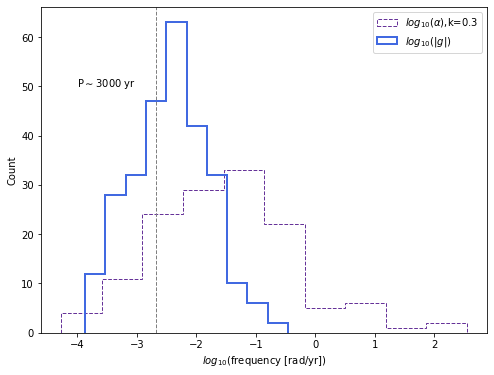

In [373]:
# get g for all pairs in system for all systems in list
allg = np.array([])
allgll = np.array([])
# select g columns, not gll columns
for colname in [s for s in allcalc.colnames if 'g ' in s]:
    #print(colname)
    gcol = allcalc[colname]
    allg = np.append(allg, np.array(gcol[~gcol.mask]))
    
# do it for g_LL, just for laughts. it looks basically the same.    
# for colname in [s for s in allcalc.colnames if 'gll' in s]:
#     #print(colname)
#     ggcol = allcalc[colname]
#     allgll = np.append(allgll, np.array(ggcol[~ggcol.mask]))


# plot histogram of g,a
fig, ax = plt.subplots(figsize=(8,6))
n, bins, patches = ax.hist(np.log10([a.value for a in allcalc['alpha']]), histtype='step', ls='--', color='rebeccapurple',label=r'$log_{10}(\alpha)$,'+f'k={k2}')
ng, binsg, patchesg = ax.hist(np.log10([np.abs(g.value) for g in allg]), 
                               histtype='step', ls='-',color='royalblue',lw=2, label=r'$log_{10}(|g|)$')
# ng, binsg, patchesg = ax.hist(np.log10([np.abs(g.value) for g in allgll]), 
#                                histtype='step', ls='-',color='pink',lw=2, label=r'$log_{10}(|g_{LL}|)$')

# add a reference line for P=300 yrs
ax.axvline(np.log10(2*np.pi/3000), color='grey',lw=1, ls='--')
ax.text(-4,50, r"P$\sim$3000 yr")

# additional formatting
ax.set_xlabel(r"$log_{10}($frequency [rad/yr])")
ax.set_ylabel(r"Count")
plt.legend()

### Calculate obliquity, $\epsilon$, required for spin-orbit resonance

$$ cos~\epsilon = \left( \frac{1}{2\alpha_{syn}/|g| ~-~1} \right)^{1/2}  $$

for $\alpha_{syn} = \alpha$ when $n = \omega$, i.e. the rotation period of the planet is the same as its orbital period 


In [473]:
# Assume Prot = Porb

# this will only work for single planet experiments

# N random values of k2, g
N = 100
k2 = np.random.rand(N)*(0.6 - 0.1) + 0.1   # Love number, randomly selected 0.1-0.6
# g/gll = 1 unless p2/p1 is 1.5-1.55, 2-2.05, then g/gll=0.3-1.0*gll
if ((P2/P1 < 1.55) & (P2/P1 > 1.5)) | ((P2/P1 < 2.05) & (P2/P1 > 2.0)):
    print(f"P2/P1 = {P2/P1:.4}, g = 0.3-1.0 * gll")
    g = gll*(np.random.rand(N)*(1. - 0.3) + 0.3)
else:
    print(f"P2/P1 = {P2/P1:.4}, g = 1 * gll")
    g = gll
alpha1 = (0.5 * (mstar/m1) * (r1/a1)**3 * (k2/get_C(k2)) * w1).to(u.Myr**-1)
alpha2 = (0.5 * (mstar/m2) * (r2/a2)**3 * (k2/get_C(k2)) * w2).to(u.Myr**-1)  #  np.random.normal(1.4e5, 3e4, N) * u.Myr**-1 # 
# print(f"alpha d: {alpha1}")
# print(f"alpha e: {alpha2}")
alpha_d_g = np.array([(alpha1 / gg).decompose() for gg in g])  # a/g for every alpha, g pair
alpha_e_g = np.array([(alpha2 / gg).decompose() for gg in g])

print(f"Drawing from {N} values of k2")
print(f"alpha_d/g: {(alpha_d_g).min():.4}--{(alpha_d_g).max():.4}")
print(f"alpha_e/g: {(alpha_e_g).min():.4}--{(alpha_e_g).max():.4}")

obl1 = np.arccos(((2*alpha_d_g) - 1)**(-0.5))*(180/np.pi)
obl2 = np.arccos(((2*alpha_e_g) - 1)**(-0.5))*(180/np.pi)
print(f"obliquity_d = {obl1.min():.4}--{obl1.max():.4} deg (P = {P1})")
print(f"obliquity_e = {obl2.min():.4}--{obl2.max():.4} deg (P = {P2})")

P2/P1 = 1.512, g = 0.3-1.0 * gll
Drawing from 100 values of k2
alpha_d/g: 3.768--38.59
alpha_e/g: 1.122--11.49
obliquity_d = 66.97--83.42 deg (P = 3.0721466 d)
obliquity_e = 26.28--77.68 deg (P = 4.6453821 d)


### Planet tilt ($\omega$) vs. day length (n)
Obliquity vs. spin frequency

$$ \frac{w_{eq}}{n} = \frac{N(e)}{\Omega(e)}\frac{2cos~\epsilon}{1 + cos^2\epsilon} $$

$ N(e=0) = \Omega(e=0) = 1$

#### Solving for $\epsilon$ when $w_{eq}/n = 1$:

$$ \epsilon = cos^{-1} \left( \frac{N(e)}{\Omega(e)} \pm  \sqrt{\left( \frac{N(e)}{\Omega(e)}\right) ^2 - 1} ~\right)$$ 

but the part under the radical is complex, so it's actually

$$ \epsilon = cos^{-1} \left( \frac{N(e)}{\Omega(e)}\right) $$

I think this makes sense because for $e=0$, $\frac{N(e)}{\Omega(e)} = 1$, so $\epsilon = 0$, so a tidally-locked planet has no obliquity, which is true. 

Text(0.5, 1.0, 'Mean rotation rate vs. travel rate for all obliquities @ e=0')

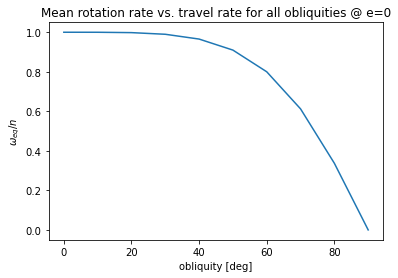

In [16]:
obl = np.arange(0,100,10) * np.pi/180
weq_n = (2 * np.cos(obl)) / (1 + np.cos(obl)**2)

plt.plot(obl*180/np.pi, weq_n)
plt.xlabel("obliquity [deg]")
plt.ylabel(r"$\omega_{eq}/n$")
plt.title("Mean rotation rate vs. travel rate for all obliquities @ e=0")

In [17]:
_obl = np.linspace(0,90,100) * np.pi/180
_ecc = np.linspace(0,0.10,100)

obl, ecc = np.meshgrid(_obl, _ecc)

Ne = (1 + (15/2)*ecc**2 + (45/8)*ecc**4 + (5/16)*ecc**6) / (1 - ecc**2)**6
Omegae = (1 + 3*ecc*2 + (3/8)*ecc**4) / (1 - ecc**2)**(9/2)
weq_n =  (2 * np.cos(obl)) / (1 + np.cos(obl)**2)# * (Ne / Omegae) 

obl_lock = np.arccos((Ne / Omegae))  # + np.sqrt((Ne/Omegae)**2 - 1)

**Note** The plot has a gradient with increasing eccentricity if you include the 
$\frac{N(e)}{\Omega(e)}$ term in the calculation for $w_{eq}/n$.

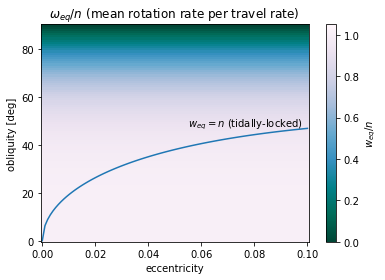

In [18]:
fig, ax = plt.subplots()
plt.grid(False)

pcm = ax.pcolormesh(ecc, obl*(180/np.pi), weq_n, 
                    cmap='PuBuGn_r', vmin=0, vmax=1.05)
plt.plot(np.unique(ecc.flatten()), np.unique((obl_lock.flatten())) * (180/np.pi), '-')

plt.text(0.055, 48, r"$w_{eq} = n$ (tidally-locked)")
plt.xlabel("eccentricity")
plt.ylabel("obliquity [deg]")
plt.title(r"$\omega_{eq}/n$ (mean rotation rate per travel rate) ")
cb = fig.colorbar(pcm)
cb.set_label(r"$w_{eq}/n$")

In [19]:
mass_data = pd.read_table("./ajaa71eft1_mrt.txt", header=70, usecols=[0])
# ecc_data = pd.read_table("./ajaa71eft2_mrt.txt", header=28)

In [20]:
mass_data.to_numpy()[0:5]

array([['Kepler-9 b    1  19.243  8.2 1.0  0.7    1.0 0.1  0.1  0  43.5   2.7  3.3    0.4   0.1  0.1  0  43.4   2.7  3.2    0.4    0.1  0.1  Ho10; Dr14; Bo14        '],
       ['Kepler-9 c    1  38.969  8.3 0.8  0.9    1.0 0.1  0.1  0  29.9   1.8  2.3    0.3   0.1  0.1  0  29.9   1.9  2.2    0.3    0.1  0.1  Ho10; Dr14; Bo14        '],
       ['Kepler-11 b   0  10.304  1.9 0.1  0.1    0.9 0.1  0.1  0   0.7   0.3  0.2    0.6   0.3  0.2  0   1.2   0.6  0.5    1.0    0.5  0.5  Li11; Mig12; Li13; Bo14 '],
       ['Kepler-11 c   0  13.025  3.0 0.2  0.2    0.9 0.1  0.1  0   1.8   0.9  0.5    0.4   0.2  0.1  0   3.4   1.4  1.5    0.7    0.4  0.3  Li11; Mig12; Li13; Bo14 '],
       ['Kepler-11 d   1  22.687  3.3 0.2  0.2    0.9 0.1  0.1  0   6.8   0.7  0.8    1.0   0.2  0.2  0   6.9   0.8  0.8    1.0    0.3  0.2  Li11; Mig12; Li13; Bo14 ']],
      dtype=object)

### g and $\alpha$ connecting to $\omega_{eq}/n$ 

If $T_g \approx T_{\alpha}$, that is **resonance** in Cassini state 2, 
and _**not**_ tidal locking, right?  This is just saying the precession period of the orbit is the same as the precession period of the planet spin. Tidal locking is when $w_{eq} = n$

Sarah has gone ahead and calculated $g$ and $\alpha_{sync} = a(n\omega)$ for M dwarfs which are also in the paper by Hadden & Lithwick. 

For $e \approx 0$, she used an expression which has $\alpha_{syn},~g$ to get $\epsilon$:

$$ cos~\epsilon = \left( \frac{1}{2\alpha_{syn}/|g| - 1} \right)^{1/2} $$. 

I will now look up the values of $w_{eq}/n$.

In [21]:
# Trappist-1 values for planet b, planet c
pl_c_obl = [69.7, 80.5, 78.3, 85.0] # min, max b-c; min-max c-d obliquity
pl_c_ag = [4.66, 19., 12.7, 66.6] # min, max b-c; min-max c-d  alpha/g
pl_c_n = 2*np.pi / (2.42 * u.d) 

Planet c rotation period range given b-c interactions: [3.92202834 7.53092573] d
Planet c rotation period range given c-d interactions: [ 6.21221586 13.71923397] d


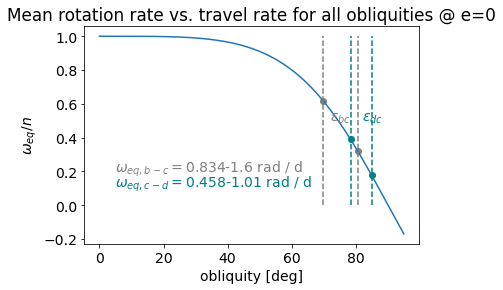

In [23]:
plt.rc('font', size=14) 
plt.xlabel("obliquity [deg]")
plt.ylabel(r"$\omega_{eq}/n$")
plt.title("Mean rotation rate vs. travel rate for all obliquities @ e=0")

obl = np.arange(0,95,0.1) * np.pi/180
weq_n = (2 * np.cos(obl)) / (1 + np.cos(obl)**2)

# mask for allowed obliquities for each planet-planet interaction
bc_obl_mask = (obl > pl_c_obl[0]*(np.pi/180) )& (obl < pl_c_obl[1]*(np.pi/180)) # deg
cd_obl_mask = (obl > pl_c_obl[2]*(np.pi/180) )& (obl < pl_c_obl[3]*(np.pi/180)) # deg

# b-on-c
weq_n_bc = [weq_n[bc_obl_mask].min(), weq_n[bc_obl_mask].max()]
weq_bc = (weq_n_bc * u.rad) * pl_c_n
print(f"Planet c rotation period range given b-c interactions: {np.sort(np.pi*2*u.rad/weq_bc)}")
plt.scatter(obl[bc_obl_mask].min()*(180/np.pi), weq_n[bc_obl_mask].max(),c='grey')
plt.scatter(obl[bc_obl_mask].max()*(180/np.pi), weq_n[bc_obl_mask].min(),c='grey')
plt.text(5,0.2, r"$\omega_{eq, b-c} = $"+f"{weq_bc[0].value:.3}-{weq_bc[1]:.3}", c='grey')

# d-on-c
weq_n_cd = [weq_n[cd_obl_mask].min(), weq_n[cd_obl_mask].max()]  # range of weq/n
weq_cd = (weq_n_cd * u.rad) * pl_c_n    
print(f"Planet c rotation period range given c-d interactions: {np.sort(np.pi*2*u.rad/weq_cd)}")
plt.scatter(obl[cd_obl_mask].min()*(180/np.pi), weq_n[cd_obl_mask].max(),c='teal')
plt.scatter(obl[cd_obl_mask].max()*(180/np.pi), weq_n[cd_obl_mask].min(),c='teal')
plt.text(5,0.11, r"$\omega_{eq, c-d} = $"+f"{weq_cd[0].value:.3}-{weq_cd[1]:.3}", c='teal')

# plot obliquity-weq/n curve
plt.plot(obl*180/np.pi, weq_n)

plt.vlines(pl_c_obl[0:2], 0,1, linestyles='--', colors='grey')
plt.text(72, 0.5, r"$\epsilon_{bc}$", c='grey')
plt.vlines(pl_c_obl[2:], 0,1, linestyles='--', colors='teal')
plt.text(82, 0.5, r"$\epsilon_{dc}$", c='teal');

saveplot=False
if saveplot:
    folder = f"TRAPPIST-1"
    if not os.path.exists(folder):
        print(f"making {folder}")
        os.makedirs(f"{folder}/plots")
    filename=f"{folder}/plots/{folder}_obliquity_weqn.pdf"
    plt.savefig(filename, bbox_inches='tight',transparent=True)
    print(f"saving figure {filename}")